<a href="https://colab.research.google.com/github/Nunuy15/Thesis/blob/main/TuningFix_MobileNetV3Small_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Tahap 1: Inisialisasi Generator Gambar**
Pada tahap ini, kita membuat ImageDataGenerator dan mengatur fungsi preprocessing agar sesuai dengan MobileNetV3.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menggunakan ImageDataGenerator dengan fungsi preprocessing MobileNetV3
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)

# **Tahap 2: Memuat Gambar dari Direktori**
Pada tahap ini, kita membuat generator gambar (train_generator) untuk menghasilkan gambar dari direktori training. Gambar-gambar ini akan diproses sesuai target size yang ditentukan.

In [ ]:
# Directories
train_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_PHOTOMETRIC/train'
val_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_PHOTOMETRIC/valid'
test_dir = '/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_PHOTOMETRIC/test'

# Ukuran gambar dan batch size
img_height, img_width = 224, 224
batch_size = 32

# Membuat generator untuk memuat gambar dari direktori
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 10710 images belonging to 6 classes.
Found 3060 images belonging to 6 classes.
Found 1530 images belonging to 6 classes.


# **Tahap 3: Fungsi untuk Menampilkan Gambar dari Setiap Kelas**
Pada tahap ini, kita membuat fungsi untuk menampilkan satu gambar acak dari setiap kelas dalam batch pertama yang dihasilkan oleh generator.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_images_from_each_class(generator, class_names, img_height=224, img_width=224):
    """
    Fungsi untuk menampilkan gambar acak dari setiap kelas dalam generator gambar.

    Parameters:
    - generator: ImageDataGenerator yang telah dikonfigurasi
    - class_names: Daftar nama kelas
    - img_height, img_width: Dimensi gambar
    """
    # Menyimpan gambar acak dari setiap kelas
    random_images = {}

    # Mengambil batch pertama dari generator
    for images, labels in generator:
        for i in range(len(images)):
            label = np.argmax(labels[i])  # Mengambil indeks kelas
            class_name = class_names[label]

            # Simpan satu gambar dari setiap kelas
            if class_name not in random_images:
                random_images[class_name] = images[i]

        # Jika sudah memiliki satu gambar dari setiap kelas, hentikan loop
        if len(random_images) == len(class_names):
            break

    # Visualisasi gambar acak dari setiap kelas
    plt.figure(figsize=(15, 8))
    for i, (class_name, image) in enumerate(random_images.items()):
        ax = plt.subplot(1, len(class_names), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis("off")
    plt.show()

# **Tahap 4: Menjalankan Fungsi dan Menampilkan Hasil**
Pada tahap ini, kita menjalankan fungsi yang telah dibuat untuk menampilkan gambar dari setiap kelas. Kita juga mengambil nama kelas dari train_generator untuk memastikan bahwa setiap kelas tercakup.

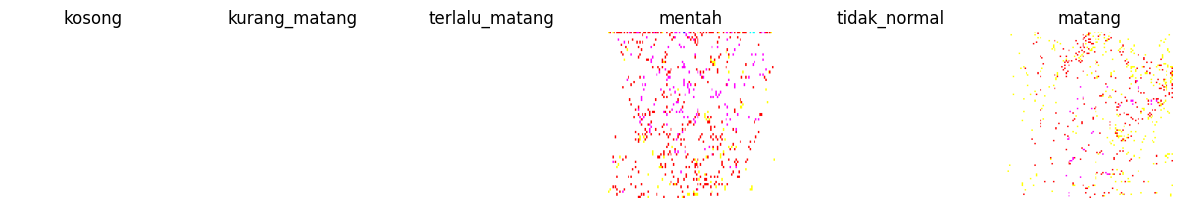

In [ ]:
# Mendapatkan nama kelas dari train_generator
class_names = list(train_generator.class_indices.keys())

# Tampilkan gambar acak dari setiap kelas
show_random_images_from_each_class(train_generator, class_names)

# **Tahap 5: Pembuatan Model**
Pada tahap ini, kita membangun model menggunakan MobileNetV3 sebagai base model, menambahkan beberapa layer tambahan untuk menyesuaikan output dengan jumlah kelas yang diinginkan.

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Load MobileNetV3 Small model sebagai base model tanpa lapisan klasifikasi teratas
base_model = MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights='imagenet',
    include_preprocessing=True
)

# Membekukan base model untuk transfer learning
base_model.trainable = False

# Menambahkan lapisan custom di atas base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)  # Batch Normalization untuk stabilisasi
x = Dropout(0.2)(x)
x = Dense(6, activation='softmax')(x)  # Output layer menyesuaikan jumlah kelas

# Definisikan model keseluruhan
model = Model(inputs=base_model.input, outputs=x)

# Compile model dengan learning rate lebih kecil untuk pelatihan yang stabil
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **Tahap 6: Melatih Model**
Melatih model menggunakan generator data yang telah dikonfigurasi sebelumnya, yaitu `train_generator` dan `val_generator`.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Menambahkan Early Stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',    # Metrik yang dipantau
#     patience=5,            # Jumlah epoch tanpa peningkatan sebelum berhenti
#     restore_best_weights=True  # Mengembalikan bobot terbaik setelah berhenti
# )

# Training model dengan Early Stopping
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 66s 170ms/step - accuracy: 0.6244 - loss: 0.9575 - val_accuracy: 0.7696 - val_loss: 0.5915
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.8239 - loss: 0.4620 - val_accuracy: 0.7820 - val_loss: 0.5935
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 45s 132ms/step - accuracy: 0.8551 - loss: 0.3713 - val_accuracy: 0.8307 - val_loss: 0.4561
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.8833 - loss: 0.3108 - val_accuracy: 0.8327 - val_loss: 0.4609
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.9088 - loss: 0.2508 - val_accuracy: 0.8484 - val_loss: 0.4082
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.9201 - loss: 0.2121 - val_accuracy: 0.8353 - val_loss: 0.4598
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.9417 - loss: 0.1628 - val_accuracy: 0.8641 - val_loss: 0.3884
Epoch 8/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.9529 - loss: 0

# **Tahap 7: Evaluasi Model**
Melakukan evaluasi pada data test dan menghasilkan laporan klasifikasi serta confusion matrix untuk mengetahui performa model pada data yang belum pernah dilihat.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Prediksi pada data test
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Laporan klasifikasi
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step
                precision    recall  f1-score      support
kosong           0.954545  0.988235  0.971098   255.000000
kurang_matang    0.839827  0.760784  0.798354   255.000000
matang           0.832740  0.917647  0.873134   255.000000
mentah           0.892308  0.909804  0.900971   255.000000
terlalu_matang   0.939271  0.909804  0.924303   255.000000
tidak_normal     0.882591  0.854902  0.868526   255.000000
accuracy         0.890196  0.890196  0.890196     0.890196
macro avg        0.890214  0.890196  0.889398  1530.000000
weighted avg     0.890214  0.890196  0.889398  1530.000000


In [ ]:
# # Evaluasi akurasi pada data testing
# test_loss, test_accuracy = model.evaluate(test_generator)

# print("Testing Accuracy:", test_accuracy)

In [ ]:
import numpy as np

# Mengambil data akurasi dan loss dari history
# train_accuracy = np.mean(history.history['accuracy'])
# val_accuracy = np.mean(history.history['val_accuracy'])
# train_loss = np.mean(history.history['loss'])
# val_loss = np.mean(history.history['val_loss'])

# print("Rata-rata Akurasi Training:", train_accuracy)
# print("Rata-rata Akurasi Validasi:", val_accuracy)
# print("Rata-rata Loss Training:", train_loss)
# print("Rata-rata Loss Validasi:", val_loss)

# Evaluasi pada training, validation, dan test set
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(val_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

335/335 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - accuracy: 0.9989 - loss: 0.0113
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.8732 - loss: 0.5155
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9113 - loss: 0.3846


In [ ]:
import pandas as pd

# Membuat tabel hasil evaluasi
data = {
    "Dataset": ["Training", "Validation", "Testing"],
    "Loss": [train_loss, val_loss, test_loss],
    "Accuracy (%)": [train_accuracy * 100, val_accuracy * 100, test_accuracy * 100]
}

df_evaluation = pd.DataFrame(data)

# Menampilkan tabel
print(df_evaluation)

      Dataset      Loss  Accuracy (%)
0    Training  0.012220     99.859941
1  Validation  0.558940     86.666667
2     Testing  0.488499     89.019608


In [ ]:
df_evaluation

,Dataset,Loss,Accuracy (%)
0,Training,0.012220,99.859941
1,Validation,0.558940,86.666667
2,Testing,0.488499,89.019608


# **Tahap 8: Visualisasi Hasil Training dan Evaluasi**

# 8.1. Visualisasi Akurasi Training dan Validation
Menampilkan grafik akurasi training dan validation dari hasil pelatihan untuk memantau kinerja model.

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


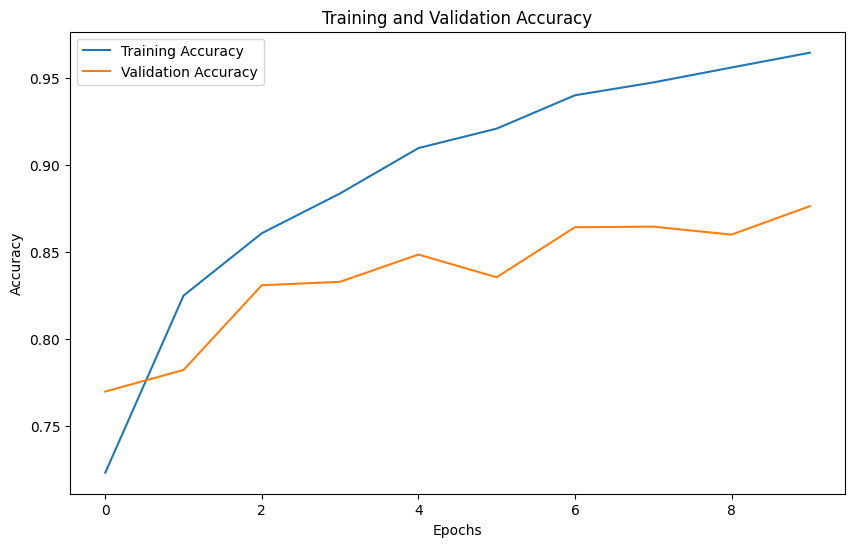

In [ ]:
import matplotlib.pyplot as plt

# Plot Akurasi Training dan Validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

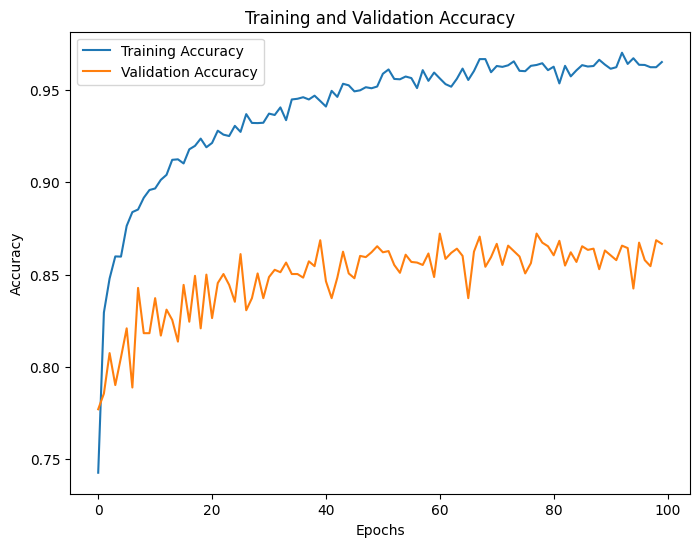

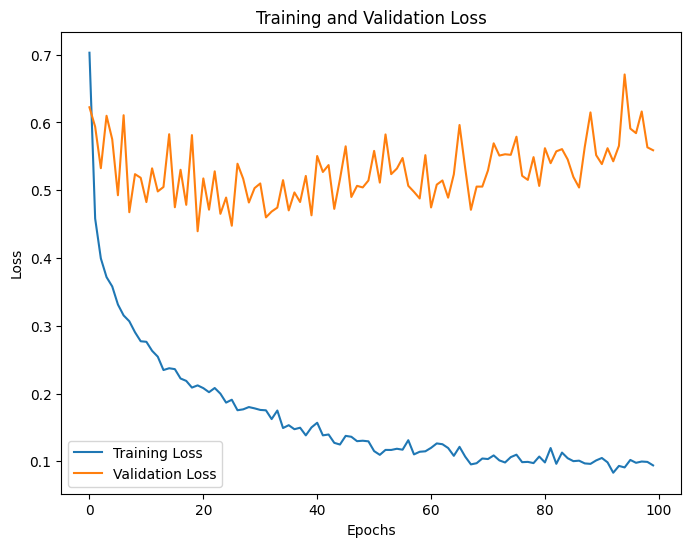

In [ ]:
import matplotlib.pyplot as plt

# Plot Akurasi Training dan Validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss Training dan Validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# 8.2. Visualisasi Precision, Recall, dan F1 Score per Kelas
Menampilkan precision, recall, dan f1-score untuk setiap kelas.

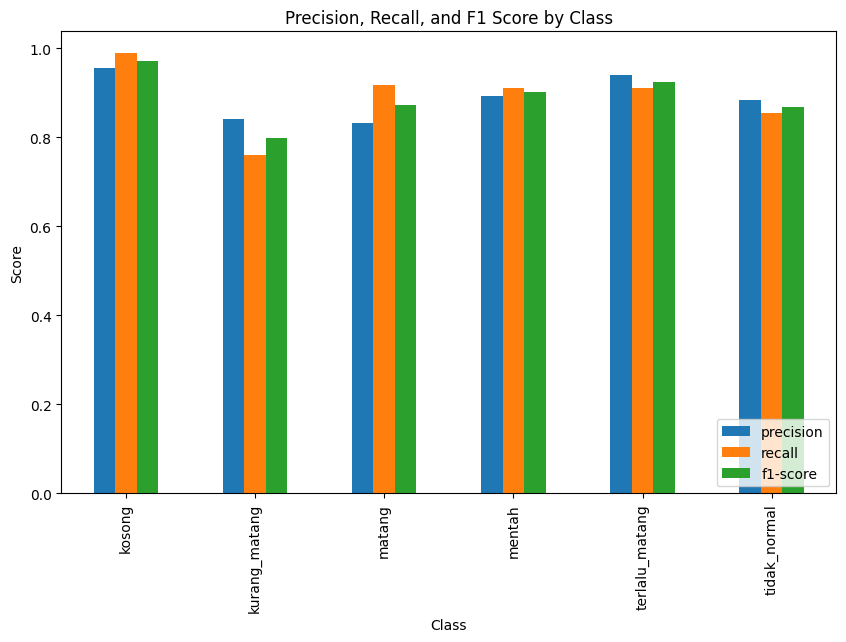

In [ ]:
# Visualisasi precision, recall, dan f1-score per kelas
df_metrics = df_report.loc[class_names, ["precision", "recall", "f1-score"]]
df_metrics.plot(kind="bar", figsize=(10, 6))
plt.title("Precision, Recall, and F1 Score by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend(loc="lower right")
plt.show()

# 8.3. Visualisasi Confusion Matrix
Menampilkan confusion matrix untuk memeriksa kesalahan klasifikasi model pada data test.

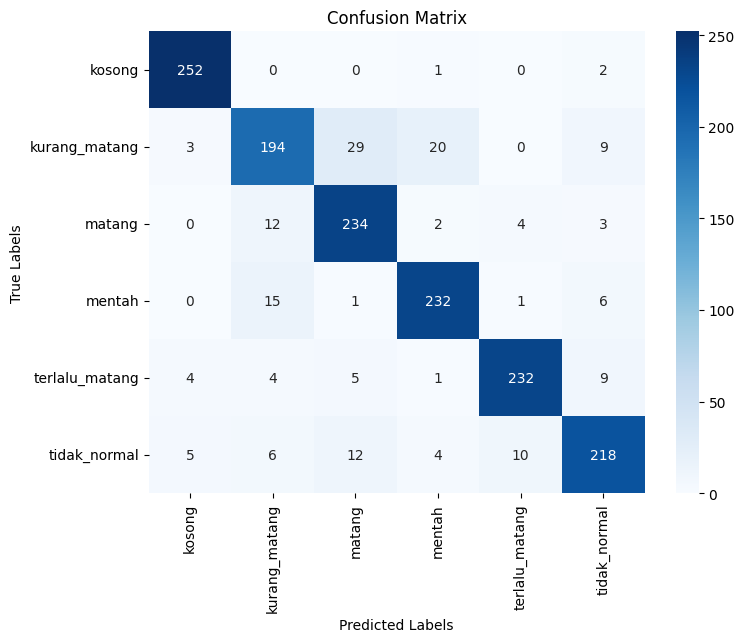

In [ ]:
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# **Tahap 9: Menyimpan Model**
Simpan model yang telah dilatih untuk digunakan di masa mendatang.

In [ ]:
# Menyimpan model
model.save('/content/drive/MyDrive/DATASET_FFB/SUHARJITO/NORMAL/DATASET_BALANCED_SPLIT_MIN/saved_model_mobileNetV3Small_HyperTuning.keras')

In [ ]:
# Menghitung rata-rata akurasi dan loss untuk Training dan Validation
training_accuracies = history.history['accuracy']
training_losses = history.history['loss']
validation_accuracies = history.history['val_accuracy']
validation_losses = history.history['val_loss']

avg_training_accuracy = sum(training_accuracies) / len(training_accuracies)
avg_training_loss = sum(training_losses) / len(training_losses)
avg_validation_accuracy = sum(validation_accuracies) / len(validation_accuracies)
avg_validation_loss = sum(validation_losses) / len(validation_losses)

print("Rata-rata Training Accuracy:", avg_training_accuracy)
print("Rata-rata Training Loss:", avg_training_loss)
print("Rata-rata Validation Accuracy:", avg_validation_accuracy)
print("Rata-rata Validation Loss:", avg_validation_loss)

# Evaluasi rata-rata pada data Testing
test_loss, test_accuracy = model.evaluate(test_generator)
print("Testing Accuracy:", test_accuracy)
print("Testing Loss:", test_loss)


Rata-rata Training Accuracy: 0.7958739030928839
Rata-rata Training Loss: 0.7862941296327681
Rata-rata Validation Accuracy: 0.8350606894209271
Rata-rata Validation Loss: 0.6976372308674312
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8939 - loss: 0.4792
Testing Accuracy: 0.8973855972290039
Testing Loss: 0.46236538887023926
